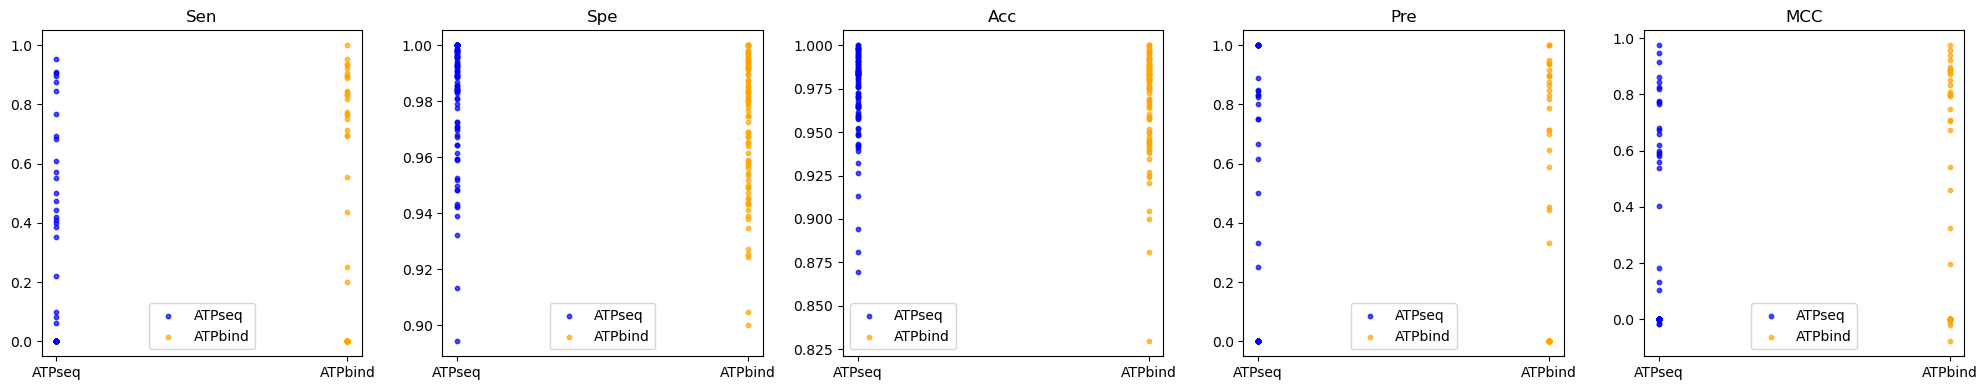

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('evaluation_results_ATPbind.csv')

# 需要绘制的指标列
metrics = ["Sen", "Spe", "Acc", "Pre", "MCC"]

# 创建并排的子图，ncols=5表示5个子图，sharey=False表示各自独立纵轴
fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 4), sharey=False)

for i, metric in enumerate(metrics):
    # pivot: 行=Prot.ID, 列=Method(ATPseq/ATPbind), 值=metric
    pivoted = df.pivot(index="Prot.ID", columns="Method", values=metric)
    pivoted.dropna(inplace=True)  # 如果某蛋白缺失某列数据则丢弃

    # 准备散点的横坐标（0: ATPseq, 1: ATPbind）
    n = len(pivoted)
    x_seq = [0] * n
    x_bind = [1] * n

    # 纵坐标
    y_seq = pivoted["ATPseq"].values
    y_bind = pivoted["ATPbind"].values

    # 在第 i 个子图上绘制散点
    # s=10 设置散点大小，alpha=0.7 设置透明度
    axes[i].scatter(x_seq, y_seq, color="blue", alpha=0.7, s=10, label="ATPseq")
    axes[i].scatter(x_bind, y_bind, color="orange", alpha=0.7, s=10, label="ATPbind")

    # 设置横坐标仅显示两个刻度
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["ATPseq", "ATPbind"])

    # 子图标题
    axes[i].set_title(metric)

    # 第一个子图设置纵轴标签
    #if i == 0:
        #axes[i].set_ylabel(metric)

    # 可以选择只在第一个或最后一个子图显示图例
    #if i == 0:
    axes[i].legend(loc="best")
    #else:
        # 其他子图不重复显示图例
        #axes[i].legend().remove()

# 调整子图布局
plt.tight_layout()
plt.show()


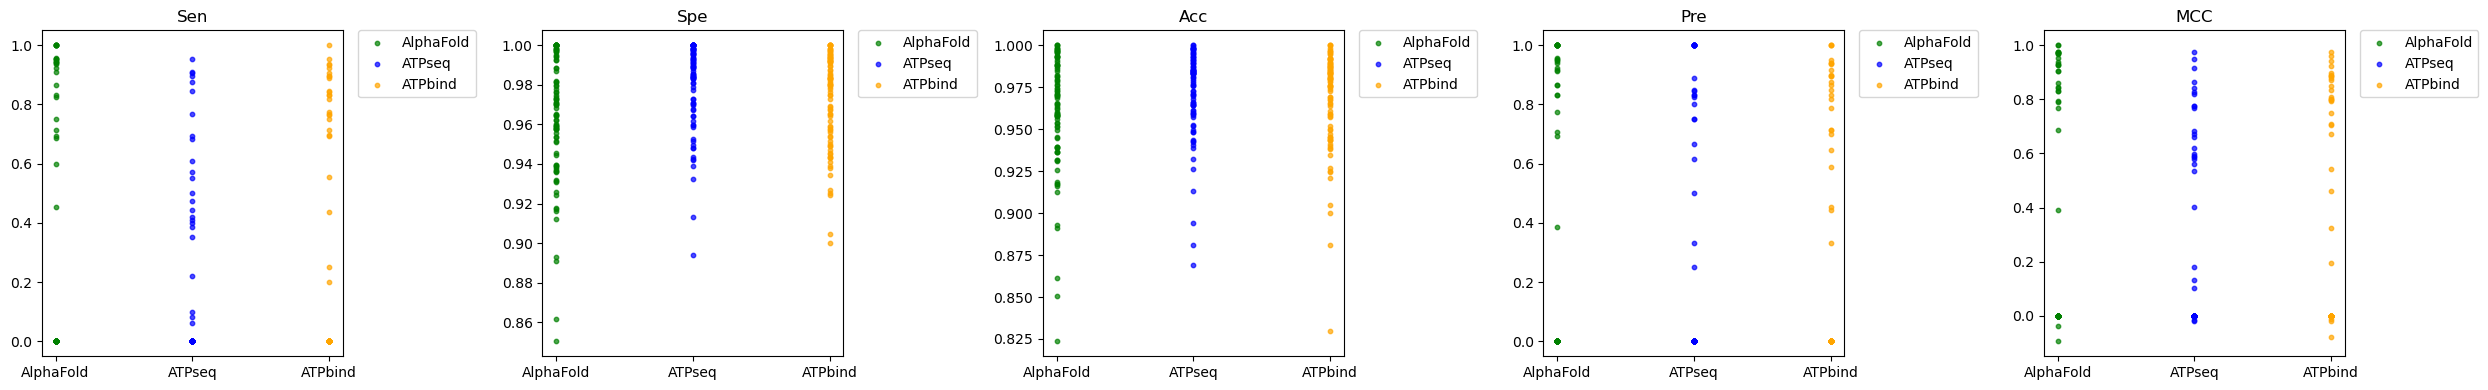

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 读取 AlphaFold CSV（图1）
alpha_df = pd.read_csv("evaluation_results_AlphaFold&Cif_full.csv")  # 列: Prot.ID, TP,FN,TN,FP,Sen,Spe,Acc,Pre,MCC
# 给它新增一列 Method = "AlphaFold"
alpha_df["Method"] = "AlphaFold"

# 2) 读取 ATPseq / ATPbind CSV（图2）
atp_df = pd.read_csv("evaluation_results_ATPbind.csv")  # 列: Prot.ID,Method,TP,FN,TN,FP,Sen,Spe,Acc,Pre,MCC
# 这里 Method 列已有 "ATPseq" 或 "ATPbind"

# 3) 合并两份数据（行拼接），得到三种方法：AlphaFold, ATPseq, ATPbind
df = pd.concat([alpha_df, atp_df], ignore_index=True)

# 需要绘制的指标
metrics = ["Sen", "Spe", "Acc", "Pre", "MCC"]

# 创建5个子图并排
fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(5*len(metrics), 4), sharey=False)

for i, metric in enumerate(metrics):
    # pivot: 行=Prot.ID, 列=Method(AlphaFold/ATPseq/ATPbind), 值=metric
    pivoted = df.pivot(index="Prot.ID", columns="Method", values=metric)
    
    # 若有蛋白缺失某方法数据，则丢弃
    pivoted.dropna(inplace=True)
    
    # x坐标：0=AlphaFold, 1=ATPseq, 2=ATPbind
    n = len(pivoted)
    x_alpha = [0]*n
    x_seq   = [1]*n
    x_bind  = [2]*n

    # 纵坐标
    # 注意先判断列是否存在，以防有些方法不在数据里
    y_alpha = pivoted["AlphaFold"].values if "AlphaFold" in pivoted.columns else []
    y_seq   = pivoted["ATPseq"].values    if "ATPseq" in pivoted.columns else []
    y_bind  = pivoted["ATPbind"].values  if "ATPbind" in pivoted.columns else []
    
    ax = axes[i]
    # 绘制散点
    ax.scatter(x_alpha, y_alpha, color="green",  alpha=0.7, s=10, label="AlphaFold")
    ax.scatter(x_seq,   y_seq,   color="blue",   alpha=0.7, s=10, label="ATPseq")
    ax.scatter(x_bind,  y_bind,  color="orange", alpha=0.7, s=10, label="ATPbind")

    # 设置横轴刻度
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["AlphaFold", "ATPseq", "ATPbind"])

    ax.set_title(metric)
    # 在第一张图上显示图例，也可以每张图都显示
    #if i == 0:
    legend = ax.legend(
    loc="upper left",           # 以 bbox_to_anchor 的左上角对齐
    bbox_to_anchor=(1.05, 1),   # (1.05,1) 表示在轴的右侧外留一些空白
    borderaxespad=0.
    )


plt.tight_layout()
plt.show()


# remove proteins without ATP

In [11]:
import os
import glob
from Bio.PDB import PDBParser, NeighborSearch
from Bio.PDB.Polypeptide import is_aa

# 指定存放 PDB 文件的文件夹路径（请替换为你的实际路径）
folder_path = 'extracted_chains'  # 存放89个PDB文件的文件夹

# 获取文件夹下所有 pdb 文件
pdb_files = glob.glob(os.path.join(folder_path, '*.pdb'))

# 初始化 PDBParser
parser = PDBParser(QUIET=True)
# 设置距离阈值，单位：Å
threshold = 4.0

# 用于存储没有 ATP 结合点的 PDB 文件名的列表
no_binding_files = []

for pdb_file in pdb_files:
    structure = parser.get_structure(os.path.basename(pdb_file), pdb_file)
    
    # 1. 查找所有 ATP 配体的原子（ATP 通常以 HETATM 记录出现）
    atp_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() == "ATP":
                    atp_atoms.extend(list(residue.get_atoms()))
                    
    # 如果没有找到 ATP 配体，则认为该文件没有 ATP 结合点
    if not atp_atoms:
        no_binding_files.append(os.path.basename(pdb_file))
        continue
    
    # 2. 收集所有标准氨基酸的原子
    protein_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if is_aa(residue, standard=True):
                    protein_atoms.extend(list(residue.get_atoms()))
                    
    # 构建邻域搜索树
    ns = NeighborSearch(protein_atoms)
    
    # 3. 对每个 ATP 原子，搜索距离在阈值内的蛋白质原子，
    #    如果至少有一个标准氨基酸残基落在此范围内，则认为存在 ATP 结合点
    binding_residues = set()
    for atp_atom in atp_atoms:
        close_atoms = ns.search(atp_atom.get_coord(), threshold)
        for atom in close_atoms:
            residue = atom.get_parent()
            if is_aa(residue, standard=True):
                binding_residues.add(residue.get_id())
    
    if not binding_residues:
        no_binding_files.append(os.path.basename(pdb_file))

# 打印没有 ATP 结合点的 PDB 文件名列表
print(f"没有 ATP 结合点的 PDB 文件:(个数：{len(no_binding_files)})")
print(no_binding_files)


没有 ATP 结合点的 PDB 文件:(个数：61)
['121p_chainA.pdb', '1f3f_chainC.pdb', '1fit_chainA.pdb', '1i58_chainA.pdb', '1k90_chainA.pdb', '1rn8_chainA.pdb', '1s1d_chainA.pdb', '1to6_chainA.pdb', '1twf_chainB.pdb', '1un9_chainA.pdb', '1vl1_chainA.pdb', '1wc6_chainB.pdb', '1yzy_chainA.pdb', '2bz0_chainA.pdb', '2f17_chainA.pdb', '2i1o_chainA.pdb', '2jg1_chainC.pdb', '2q16_chainB.pdb', '2x14_chainA.pdb', '2xan_chainA.pdb', '3c1m_chainC.pdb', '3erc_chainC.pdb', '3f2b_chainA.pdb', '3jqm_chainB.pdb', '3ruv_chainD.pdb', '3vth_chainA.pdb', '3wgu_chainC.pdb', '4amf_chainA.pdb', '4crj_chainA.pdb', '4edk_chainA.pdb', '4lac_chainC.pdb', '4ru9_chainA.pdb', '4uxx_chainC.pdb', '4yvz_chainA.pdb', '5dd7_chainA.pdb', '5dgh_chainA.pdb', '5guf_chainA.pdb', '5trd_chainA.pdb', '5w51_chainE.pdb', '6a8p_chainB.pdb', '6b5k_chainA.pdb', '6c02_chainA.pdb', '6cau_chainA.pdb', '6ci7_chainC.pdb', '6fl4_chainA.pdb', '6ig2_chainD.pdb', '6p1p_chainA.pdb', '6r5d_chainA.pdb', '6sqz_chainD.pdb', '6t0v_chainB.pdb', '6txe_chainA.pdb', '6v

In [13]:
# 假设 excluded_list 如下：
excluded_list = no_binding_files

# 方法1：切片
# 如果确认每一项都以 ".pdb" 结尾，可以用 item[:-4]
excluded_list_no_pdb = [item[:-4] for item in excluded_list]

print(excluded_list_no_pdb)

['121p_chainA', '1f3f_chainC', '1fit_chainA', '1i58_chainA', '1k90_chainA', '1rn8_chainA', '1s1d_chainA', '1to6_chainA', '1twf_chainB', '1un9_chainA', '1vl1_chainA', '1wc6_chainB', '1yzy_chainA', '2bz0_chainA', '2f17_chainA', '2i1o_chainA', '2jg1_chainC', '2q16_chainB', '2x14_chainA', '2xan_chainA', '3c1m_chainC', '3erc_chainC', '3f2b_chainA', '3jqm_chainB', '3ruv_chainD', '3vth_chainA', '3wgu_chainC', '4amf_chainA', '4crj_chainA', '4edk_chainA', '4lac_chainC', '4ru9_chainA', '4uxx_chainC', '4yvz_chainA', '5dd7_chainA', '5dgh_chainA', '5guf_chainA', '5trd_chainA', '5w51_chainE', '6a8p_chainB', '6b5k_chainA', '6c02_chainA', '6cau_chainA', '6ci7_chainC', '6fl4_chainA', '6ig2_chainD', '6p1p_chainA', '6r5d_chainA', '6sqz_chainD', '6t0v_chainB', '6txe_chainA', '6vd0_chainA', '7alr_chainA', '7cqq_chainA', '7d8i_chainA', '7edz_chainC', '7fgg_chainA', '7uld_chainA', '7v0f_chainA', '7y7p_chainA', '8dcd_chainA']


In [14]:
import pandas as pd

# 1) 读取原始AlphaFold CSV
df = pd.read_csv("evaluation_results_AlphaFold&Cif_full.csv")

# 2) 需要删除的 Prot.ID 列表
excluded_list = excluded_list_no_pdb  # 示例

# 3) 从df里排除掉这些行
df_filtered = df[~df["Prot.ID"].isin(excluded_list)]

# 4) 将过滤后的结果写到新文件
df_filtered.to_csv("AlphaFold_Atp.csv", index=False)

print("过滤完成，新的CSV已生成。")


过滤完成，新的CSV已生成。


In [15]:
import pandas as pd

# 1) 读取原始AlphaFold CSV
df = pd.read_csv("evaluation_results_ATPbind.csv")

# 2) 需要删除的 Prot.ID 列表
excluded_list = excluded_list_no_pdb  # 示例

# 3) 从df里排除掉这些行
df_filtered = df[~df["Prot.ID"].isin(excluded_list)]

# 4) 将过滤后的结果写到新文件
df_filtered.to_csv("ATPbind_Atp.csv", index=False)

print("过滤完成，新的CSV已生成。")


过滤完成，新的CSV已生成。


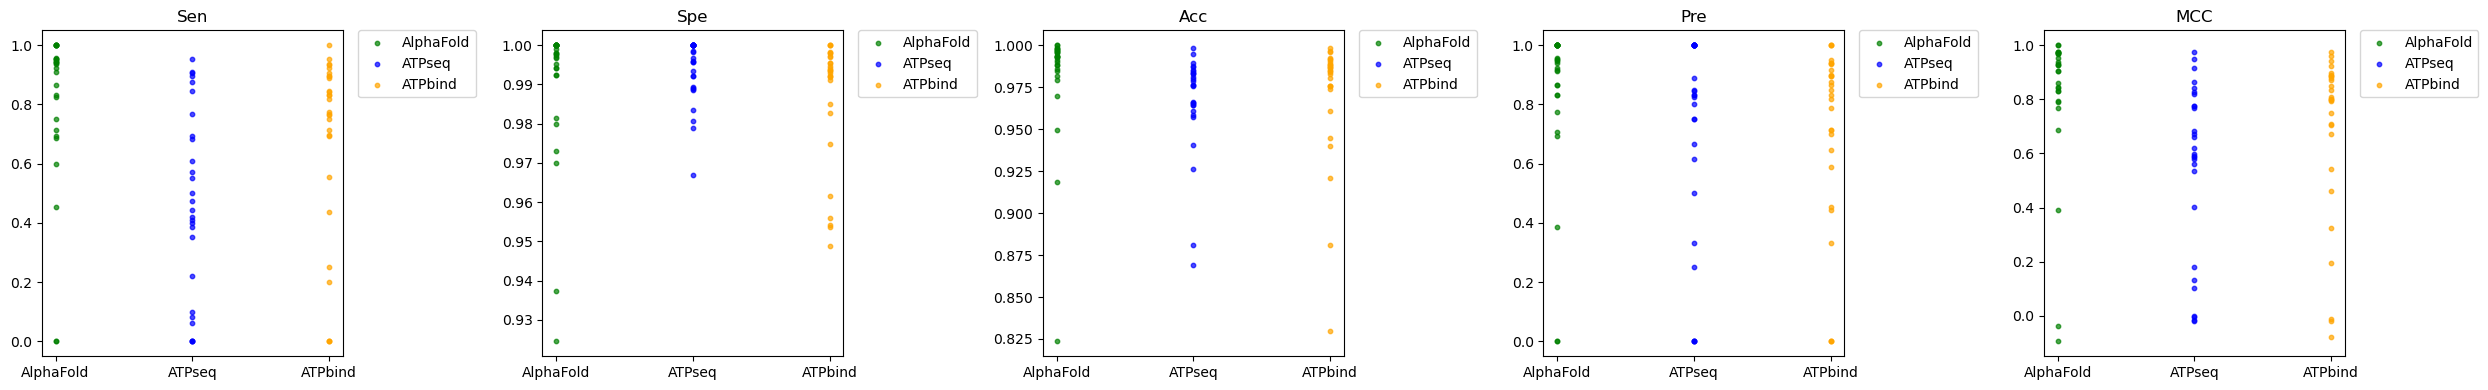

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 读取 AlphaFold CSV（图1）
alpha_df = pd.read_csv("AlphaFold_Atp.csv")  # 列: Prot.ID, TP,FN,TN,FP,Sen,Spe,Acc,Pre,MCC
# 给它新增一列 Method = "AlphaFold"
alpha_df["Method"] = "AlphaFold"

# 2) 读取 ATPseq / ATPbind CSV（图2）
atp_df = pd.read_csv("ATPbind_Atp.csv")  # 列: Prot.ID,Method,TP,FN,TN,FP,Sen,Spe,Acc,Pre,MCC
# 这里 Method 列已有 "ATPseq" 或 "ATPbind"

# 3) 合并两份数据（行拼接），得到三种方法：AlphaFold, ATPseq, ATPbind
df = pd.concat([alpha_df, atp_df], ignore_index=True)

# 需要绘制的指标
metrics = ["Sen", "Spe", "Acc", "Pre", "MCC"]

# 创建5个子图并排
fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(5*len(metrics), 4), sharey=False)

for i, metric in enumerate(metrics):
    # pivot: 行=Prot.ID, 列=Method(AlphaFold/ATPseq/ATPbind), 值=metric
    pivoted = df.pivot(index="Prot.ID", columns="Method", values=metric)
    
    # 若有蛋白缺失某方法数据，则丢弃
    pivoted.dropna(inplace=True)
    
    # x坐标：0=AlphaFold, 1=ATPseq, 2=ATPbind
    n = len(pivoted)
    x_alpha = [0]*n
    x_seq   = [1]*n
    x_bind  = [2]*n

    # 纵坐标
    # 注意先判断列是否存在，以防有些方法不在数据里
    y_alpha = pivoted["AlphaFold"].values if "AlphaFold" in pivoted.columns else []
    y_seq   = pivoted["ATPseq"].values    if "ATPseq" in pivoted.columns else []
    y_bind  = pivoted["ATPbind"].values  if "ATPbind" in pivoted.columns else []
    
    ax = axes[i]
    # 绘制散点
    ax.scatter(x_alpha, y_alpha, color="green",  alpha=0.7, s=10, label="AlphaFold")
    ax.scatter(x_seq,   y_seq,   color="blue",   alpha=0.7, s=10, label="ATPseq")
    ax.scatter(x_bind,  y_bind,  color="orange", alpha=0.7, s=10, label="ATPbind")

    # 设置横轴刻度
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["AlphaFold", "ATPseq", "ATPbind"])

    ax.set_title(metric)
    # 在第一张图上显示图例，也可以每张图都显示
    #if i == 0:
    legend = ax.legend(
    loc="upper left",           # 以 bbox_to_anchor 的左上角对齐
    bbox_to_anchor=(1.05, 1),   # (1.05,1) 表示在轴的右侧外留一些空白
    borderaxespad=0.
    )


plt.tight_layout()
plt.show()
